# TFM - Evaluación de varias CNNs
## Ismael Franco Hernando
#### Imports

In [2]:
from tensorflow import keras
from mysql.connector import (connection)
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Reshape, Conv2D, MaxPooling2D, Concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import os

In [3]:
try:
    cnx = connection.MySQLConnection(user='leer', 
                                     password='candanal',
                                     host='138.100.82.178',
                                     database='deepquality_tmp')

except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrecto")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos no existe")
    else:
        print(err)

In [4]:
# Guardamos y mostramos las bobinas 
q01 = "SELECT * FROM FEATURES_1D"
fea1D = pd.read_sql(q01,cnx)
fea1D

,COILID,MID,ZNMAX_FAILURES,ZNMIN_FAILURES,CALIBRATED,TOTAL_TILEID,L_DIS,R_DIS,MAP,DECISSION_OP
0,225216688,123.0,0,6,0,26,13,12,"[-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1...",OK
1,225216688,124.0,4,0,0,26,3,6,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
2,225216688,201.0,1,1,0,26,3,4,"[-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
3,225216688,202.0,1,1,0,26,13,13,"[1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",OK
4,225220725,123.0,2,5,0,54,17,27,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, -1, 0, -1, 0, -...",OK
...,...,...,...,...,...,...,...,...,...,...
4635,233652453,202.0,2,0,0,16,8,8,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]",OK
4636,233667056,123.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4637,233667056,124.0,1,1,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4638,233667056,201.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK


In [5]:
# Guardamos y mostramos las bobinas 
q02 = "SELECT * FROM FEATURES_2D"
fea2D = pd.read_sql(q02,cnx)
fea2D

,COILID,MID,ZNMAX_FAILURES,ZNMIN_FAILURES,CALIBRATED,TOTAL_TILEID,L_DIS,R_DIS,MAP,DECISSION_OP
0,225216688,1234.0,7,61,0,576,288,282,"[0, 0, -1, 0, 0, -1, -1, -1, -1, 0, 0, -1, -1,...",OK
1,225216688,1243.0,56,46,0,576,288,286,"[0, 0, -1, -1, 1, 0, 0, 1, 1, 0, 0, -1, -1, 1,...",OK
2,225220725,1234.0,105,30,0,1197,590,598,"[-1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1...",OK
3,225220725,1243.0,77,25,0,1197,595,595,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4,225221499,1234.0,10,65,0,720,360,360,"[1, 1, 1, 1, 1, 0, 0, -1, -1, 1, 1, 1, 1, 1, 0...",OK
...,...,...,...,...,...,...,...,...,...,...
2315,233651834,1243.0,5,80,0,729,364,364,"[0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",OK
2316,233652453,1234.0,10,18,0,351,175,175,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",OK
2317,233652453,1243.0,32,22,0,351,172,172,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",OK
2318,233667056,1234.0,9,3,0,576,288,288,"[0, 0, 0, 0, 1, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0,...",OK


In [6]:
# Se cierra la conexión con la base de datos
cnx.close()

In [7]:
def unionMapas1D(datos):
    bobinas = datos['COILID'].unique()
    sensores = [(123.0, 124.0), (201.0, 202.0)]
    X = np.zeros(int(len(datos)/2)).tolist()
    Y = []
    contadorID = 0
    
    for bob in bobinas:
        for s in sensores:
            mapa1 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[0]].MAP.iloc[0]      
            mapa1 = np.array(mapa1[1:-1].split(',')).astype(int)
            mapa2 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[1]].MAP.iloc[0]      
            mapa2 = np.array(mapa2[1:-1].split(',')).astype(int)
            X[contadorID] = np.concatenate((mapa1, mapa2), axis=0)
            Y.append(datos.loc[datos['COILID']==bob].DECISSION_OP.iloc[0])
            contadorID+=1
            
    return X,Y      

In [8]:
Xori,Yori = unionMapas1D(fea1D)

In [9]:
def normalizaData(datos):
    datosNormalizados = (datos - datos.min())/(datos.max() - datos.min()).tolist()
    unionCaras = []
    
    for i in range(0, len(datosNormalizados), 2):
        cara1 = datosNormalizados[i]
        cara2 = datosNormalizados[i + 1]
        unionCaras.append(np.concatenate((cara1,cara2), axis=0))
        
    return unionCaras
    

In [10]:
XNorm = normalizaData(fea1D.iloc[:, 2:8].values)

In [11]:
def separaMuestra(X, XNorm, Y, tam_muestraOK=50, tam_muestraNOK=150):
    muestraXOK = []
    muestraYOK = []
    muestraXNOK = []
    muestraYNOK = []
    muestraXNormOK = []
    muestraXNormNOK = []

    # Se recorren los valores de manera inversa, para no tener problema con las posiciones
    for i in reversed(range(len(Y))):
        # Label de la posición i
        label = Y[i]

        # Comprobamos si la label es OK y si no se han añadido suficientes valores a la muestra
        if (label == 'OK') and (len(muestraYOK)<tam_muestraOK):
            # Se añaden los valores X e Y a la muestra
            muestraYOK.append(label)
            muestraXOK.append(X[i])
            muestraXNormOK.append(XNorm[i])
            # Se eliminan de los datos originales
            X.pop(i)
            Y.pop(i)
            XNorm.pop(i)

        # Comprobamos si la label es NOK y si no se han añadido suficientes valores a la muestra
        elif (label == 'NOK') and (len(muestraYNOK)<tam_muestraNOK):
            # Se añaden los valores X e Y a la muestra
            muestraYNOK.append(label)
            muestraXNOK.append(X[i])
            muestraXNormNOK.append(XNorm[i])
            # Se eliminan de los datos originales
            X.pop(i)
            Y.pop(i)
            XNorm.pop(i)

        # Se comprueba si ya se cuenta con suficientes datos y se hace un break del for
        elif (len(muestraYNOK) == tam_muestraNOK) and (len(muestraYOK) == tam_muestraOK):
            break
            
            
    # Se unen las muestras de OK y NOK
    muestraX = muestraXOK + muestraXNOK
    muestraY = muestraYOK + muestraYNOK
    muestraXNorm = muestraXNormOK + muestraXNormNOK
    
    return muestraX, muestraY, muestraXNorm, X, Y, XNorm
    

In [12]:
muestraX, muestraY, muestraXNorm, X, Y, XNorm = separaMuestra(Xori, XNorm, Yori)

In [13]:
def preprocesado(X,Y, maxLongitud=None, overSampl=False):
    flag = False
    if maxLongitud is None:
        flag = True
        longitudes = []
        for x in X:
            longitudes.append(len(x))

        maxLongitud = max(longitudes)
    
    nuevoX = []
    for x in X:
        nuevoX.append(np.pad(x, (0,maxLongitud-len(x)), 'constant', constant_values= 0))        
    
    
    nuevoY = []
    for y in Y:
        if y == 'OK':
            nuevoY.append(0)
        else:
            nuevoY.append(1) 

    Y = nuevoY
    
    if overSampl:        
        sm = SMOTE()
        X, Y = sm.fit_resample(nuevoX, Y)
        X = np.expand_dims(X, axis=-1)
    else:
        X = np.expand_dims(nuevoX, axis=-1)
    
    if flag:
        return maxLongitud, X, Y
    else:
        return X, Y

In [14]:
maxLongitud, X, Y = preprocesado(X,Y,overSampl=True)

In [15]:
maxLongitud, Xori, Yori = preprocesado(Xori,Yori)

In [16]:
muestraX, muestraY = preprocesado(muestraX,muestraY,maxLongitud)

In [17]:
def modeloCV(X, Y, muestraX, muestraY, maxLongitud, filters=32, kernel=3, epochs=300, batch_size=100):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):        
        modelo = Sequential();
        modelo.add(Conv1D(filters, kernel, activation='relu', input_shape=(maxLongitud, 1)))
        modelo.add(MaxPooling1D(2))
        modelo.add(Flatten())
        modelo.add(Dense(32, activation='relu'))
        modelo.add(Dense(8, activation='relu'))
        modelo.add(Dense(1, activation='relu'))

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit(X[train], Y[train], epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate(muestraX,  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [81]:
def modeloCVNorm(X, XNorm, Y, muestraX, muestraXNorm, muestraY, maxLongitud, 
                 filters=32, kernel=3, epochs=300, batch_size=100):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):
        inputs1 = Input(shape= (maxLongitud, 1))
        conv1 = Conv1D(filters, kernel, activation='relu')(inputs1)
        pool1 = MaxPooling1D(2)(conv1)
        flat1 = Flatten()(pool1)
        
        inputs2 = Input(shape= (12,))
        
        conca = Concatenate()([flat1, inputs2])
        
        output = Dense(32, activation='relu')(conca)
        output = Dense(8, activation='relu')(output)
        output = Dense(1, activation='relu')(output)
        
        modelo = Model(inputs=[inputs1, inputs2], outputs=output)
        

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit([X[train], XNorm[train]], Y[train], epochs=epochs, batch_size=batch_size, 
                             verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate([muestraX, muestraXNorm],  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [46]:
def evaluaModelo(modelos, muestraX, muestraY, criterio, mostrar=True):
    predicciones = np.zeros((len(muestraY),1))
    
    for m in modelos:
        predicciones = np.sum([predicciones, m.predict(muestraX)], axis=0)

    predicciones = predicciones/len(modelos)
    
    Yprocesada = []
    for y in predicciones:
        if y <= criterio:
            Yprocesada.append(0)
        else:
            Yprocesada.append(1)
    
    if mostrar:
        # Se muestra la matriz de confusión
        tn, fp, fn, tp = confusion_matrix(muestraY, Yprocesada).ravel()
        print("\nLa precisión obtenida ha sido", (tn+tp)/(tn+fp+fn+tp))
        print("La matriz de confusion obtenida es:\n", confusion_matrix(muestraY, Yprocesada))
    else:
        return Yprocesada

In [79]:
def curvasROC():
    modelos, historial = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud)
    criterios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]    
    fig, axs = plt.subplots(2, 3, figsize=(12, 10))
    
    
    for i, criterio in enumerate(criterios):
        predicciones = evaluaModelo(modelos, muestraX, muestraY, criterio, mostrar=False)
        fpr, tpr, thresholds = roc_curve(muestraY, predicciones,)
        roc_auc = auc(fpr, tpr)
        
        fila = i // 3
        col = i % 3
        
        axs[fila, col].plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
        axs[fila, col].plot([0, 1], [0, 1], '--', label='Clasificador aleatorio')
        axs[fila, col].set_xlabel('False Positive Rate')
        axs[fila, col].set_ylabel('True Positive Rate')
        axs[fila, col].set_title('Curva ROC (Criterio = %0.2f)' % criterio)
        axs[fila, col].legend(loc="lower right")

    plt.show()

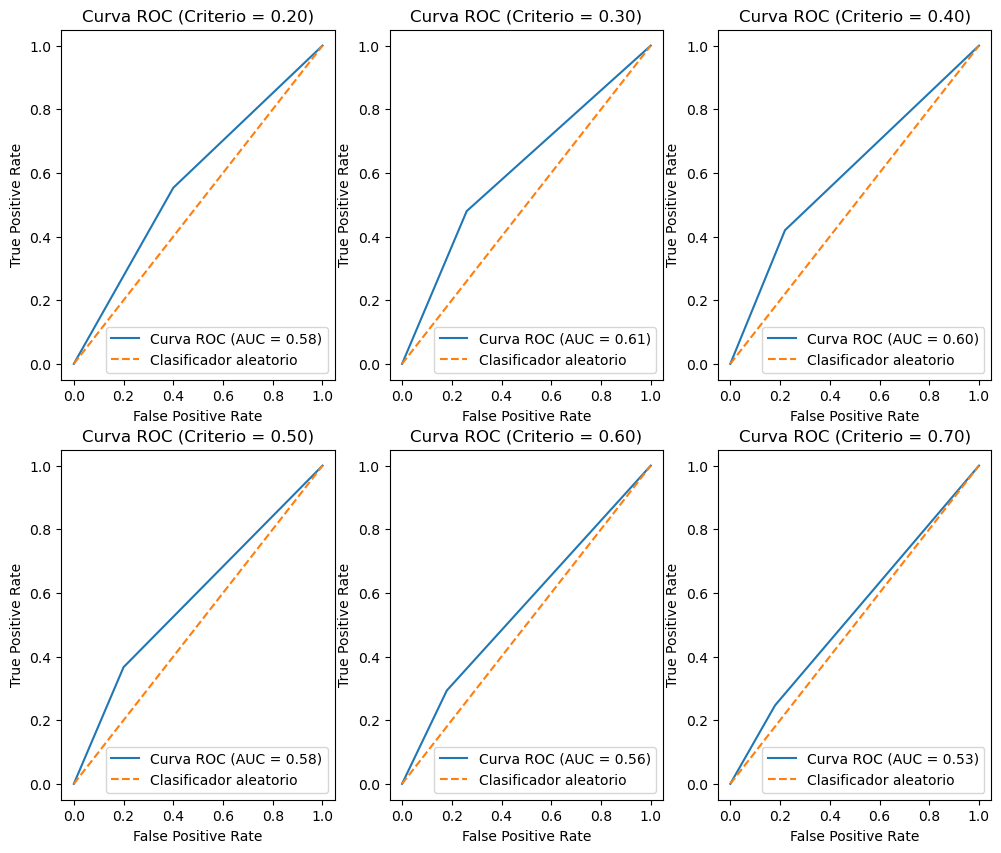

In [80]:
curvasROC()

### Experimentos 1D

#### Solo mapa de la bobina

In [18]:
modelos, historial = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud)
evaluaModelo(modelos, muestraX, muestraY)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Modelo 1

El test loss obtenido ha sido: 6.686126441955566
La precisión obtenida ha sido: 0.425

Modelo 2

El test loss obtenido ha sido: 5.935306148529053
La precisión obtenida ha sido: 0.49

Modelo 3

El test loss obtenido ha sido: 5.338688049316406
La precisión obtenida ha sido: 0.505

Modelo 4

El test loss obtenido ha sido: 6.569557113647461
La precisión obtenida ha sido: 0.46

Modelo 5

El test loss obtenido ha sido: 6.752037353515625
La precisión obtenida ha sido: 0.455

La precisión obtenida ha sido 0.485
La matriz de confusion obtenida es:
 [[32 18]
 [85 65]]


In [19]:
modelos2, historial2 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, epochs=500, kernel=5, filters=64)
evaluaModelo(modelos2, muestraX, muestraY)


Modelo 1

El test loss obtenido ha sido: 7.036540718078613
La precisión obtenida ha sido: 0.495

Modelo 2

El test loss obtenido ha sido: 7.294463500976563
La precisión obtenida ha sido: 0.47

Modelo 3

El test loss obtenido ha sido: 5.305611076354981
La precisión obtenida ha sido: 0.525

Modelo 4

El test loss obtenido ha sido: 7.09492057800293
La precisión obtenida ha sido: 0.44

Modelo 5

El test loss obtenido ha sido: 5.965381946563721
La precisión obtenida ha sido: 0.45

La precisión obtenida ha sido 0.495
La matriz de confusion obtenida es:
 [[39 11]
 [90 60]]


In [20]:
modelos3, historial3 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, filters=16)
evaluaModelo(modelos3, muestraX, muestraY)


Modelo 1

El test loss obtenido ha sido: 6.866529884338379
La precisión obtenida ha sido: 0.465

Modelo 2

El test loss obtenido ha sido: 7.024164772033691
La precisión obtenida ha sido: 0.445

Modelo 3

El test loss obtenido ha sido: 6.311352081298828
La precisión obtenida ha sido: 0.49

Modelo 4

El test loss obtenido ha sido: 7.061617488861084
La precisión obtenida ha sido: 0.425

Modelo 5

El test loss obtenido ha sido: 6.103813285827637
La precisión obtenida ha sido: 0.51

La precisión obtenida ha sido 0.505
La matriz de confusion obtenida es:
 [[38 12]
 [87 63]]


In [21]:
modelos4, historial4 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, kernel=5, filters=16)
evaluaModelo(modelos4, muestraX, muestraY)


Modelo 1

El test loss obtenido ha sido: 7.051672782897949
La precisión obtenida ha sido: 0.485

Modelo 2

El test loss obtenido ha sido: 5.486813635826111
La precisión obtenida ha sido: 0.52

Modelo 3

El test loss obtenido ha sido: 5.524809265136719
La precisión obtenida ha sido: 0.525

Modelo 4

El test loss obtenido ha sido: 6.102481422424316
La precisión obtenida ha sido: 0.44

Modelo 5

El test loss obtenido ha sido: 6.984367866516113
La precisión obtenida ha sido: 0.445

La precisión obtenida ha sido 0.505
La matriz de confusion obtenida es:
 [[40 10]
 [89 61]]


In [22]:
modelos5, historial5 = modeloCV(np.array(X), np.array(Y), muestraX, muestraY, maxLongitud, epochs=500)
evaluaModelo(modelos5, muestraX, muestraY)


Modelo 1

El test loss obtenido ha sido: 6.61274600982666
La precisión obtenida ha sido: 0.435

Modelo 2

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 3

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 4

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 5

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

La precisión obtenida ha sido 0.255
La matriz de confusion obtenida es:
 [[ 50   0]
 [149   1]]


#### Mapa de la bobina + Atributos normalizados

In [82]:
modelosNorm1, historial = modeloCVNorm(np.array(Xori), np.array(XNorm), np.array(Yori), np.array(muestraX), 
                                       np.array(muestraXNorm), muestraY, maxLongitud)
evaluaModelo(modelosNorm1, [np.array(muestraX), np.array(muestraXNorm)], muestraY, criterio=0.3)


Modelo 1

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 2

El test loss obtenido ha sido: 1.461192662715912
La precisión obtenida ha sido: 0.315

Modelo 3

El test loss obtenido ha sido: 2.204214277267456
La precisión obtenida ha sido: 0.33

Modelo 4

El test loss obtenido ha sido: 1.2757164692878724
La precisión obtenida ha sido: 0.295

Modelo 5

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

La precisión obtenida ha sido 0.29
La matriz de confusion obtenida es:
 [[ 47   3]
 [139  11]]


### Experimentos 2D

In [90]:
def mapa2D(datos):
    bobinas = datos['COILID'].unique()
    sensores = [1234.0, 1243.0]
    X = np.zeros(len(datos)).tolist()
    Y = []
    contadorID = 0
    
    for bob in bobinas:
        for s in sensores:
            mapa = datos.loc[datos['COILID']==bob].loc[datos['MID']==s].MAP.iloc[0]
            mapa = np.array(mapa[1:-1].split(',')).astype(int)
            X[contadorID] = mapa
            Y.append(datos.loc[datos['COILID']==bob].DECISSION_OP.iloc[0])
            contadorID+=1
            
    return X,Y    

In [91]:
X2ori,Y2ori = mapa2D(fea2D)

In [105]:
def normalizaData2D(datos):
    return (datos - datos.min())/(datos.max() - datos.min()).tolist()

In [103]:
XNorm2 = normalizaData2D(fea2D.iloc[:, 2:8].values)

In [106]:
muestraX2, muestraY2, muestraXNorm2, X2, Y2, XNorm2 = separaMuestra(X2ori, XNorm2.tolist(), Y2ori)

In [107]:
def preprocesado2D(X,Y, maxLongitud=None, overSampl=False):
    flag = False
    if maxLongitud is None:
        flag = True
        longitudes = []
        for x in X:
            longitudes.append(len(x))

        maxLongitud = max(longitudes)
    
    nuevoX = []
    for x in X:
        nuevoX.append(np.pad(x, (0,maxLongitud-len(x)), 'constant', constant_values= 0).reshape(9, -1, order='F'))        
    
    X = nuevoX
    nuevoY = []
    for y in Y:
        if y == 'OK':
            nuevoY.append(0)
        else:
            nuevoY.append(1) 

    Y = nuevoY  
   
    
    if flag:
        return maxLongitud, np.array(X), Y
    else:
        return np.array(X), Y

In [108]:
maxLongitud, X2, Y2 = preprocesado2D(X2,Y2,overSampl=False)

In [109]:
muestraX2, muestraY2 = preprocesado2D(muestraX2,muestraY2, maxLongitud)

In [33]:
def modelo2DCV(X, Y, muestraX, muestraY, maxLongitud, filters=32, kernel=(3,3), epochs=100, batch_size=50):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):        
        modelo = Sequential()
        modelo.add(Reshape((9, int(maxLongitud/9), 1), input_shape=(9, int(maxLongitud/9))))
        modelo.add(Conv2D(filters, kernel, activation='relu'))
        modelo.add(MaxPooling2D((2,2)))
        modelo.add(Flatten())
        modelo.add(Dense(32, activation='relu'))
        modelo.add(Dense(8, activation='relu'))
        modelo.add(Dense(1, activation='relu'))

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit(X[train], Y[train], epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate(muestraX,  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [114]:
def modelo2DCVNorm(X, XNorm, Y, muestraX, muestraXNorm, muestraY, maxLongitud, 
                 filters=32, kernel=(3,3), epochs=100, batch_size=50):
    # Validación cruzada de 5 modelos
    kfold = KFold(5)
    
    os.makedirs('tmp/checkpoint', exist_ok=True)
    filepath="tmp/checkpoint/best.hdf5"
    
    # Contador del número de modelo que se esta construyendo
    kContador = 1
    # Listas que contendrán los modelos generados junto con su historial
    modelos = []
    historial = []

    for train, test in kfold.split(X, Y):
        inputs1 = Input(shape=(9, int(maxLongitud/9)))
        res1 = Reshape((9, int(maxLongitud/9), 1))(inputs1)
        conv2d1 = Conv2D(filters, kernel, activation='relu')(res1)                    
        pool1 = MaxPooling2D((2,2))(conv2d1)
        flat1 = Flatten()(pool1)
        
        inputs2 = Input(shape= (6,))
        
        conca = Concatenate()([flat1, inputs2])
        
        output = Dense(32, activation='relu')(conca)
        output = Dense(8, activation='relu')(output)
        output = Dense(1, activation='relu')(output)
        
        modelo = Model(inputs=[inputs1, inputs2], outputs=output)
        

        # Se compila el modelo
        modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
        checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
        # Se entrena el modelo y se guarda el histotial y el modelo
        proceso = modelo.fit([X[train], XNorm[train]], Y[train], epochs=epochs, batch_size=batch_size, 
                             verbose=0, callbacks=[checkpoint])
        historial.append(proceso)
        modelo.load_weights(filepath)
        modelos.append(modelo)

        # Se evalua el modelo y se muestra
        resultado  = modelo.evaluate([muestraX, muestraXNorm],  muestraY, verbose=0)
        print("\nModelo", kContador)
        print("\nEl test loss obtenido ha sido:", resultado[0])
        print("La precisión obtenida ha sido:", resultado[1])

        # Se incrementa en 1 el contador de modelos
        kContador+=1
        
    
    return modelos, historial

In [34]:
modelos6, historial6 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud)
evaluaModelo(modelos6, muestraX2, muestraY2)


Modelo 1

El test loss obtenido ha sido: 6.915815601348877
La precisión obtenida ha sido: 0.395

Modelo 2

El test loss obtenido ha sido: 7.829189128875733
La precisión obtenida ha sido: 0.37

Modelo 3

El test loss obtenido ha sido: 5.85166836977005
La precisión obtenida ha sido: 0.405

Modelo 4

El test loss obtenido ha sido: 5.63406886100769
La precisión obtenida ha sido: 0.46

Modelo 5

El test loss obtenido ha sido: 6.658918552398681
La precisión obtenida ha sido: 0.425

La precisión obtenida ha sido 0.415
La matriz de confusion obtenida es:
 [[ 46   4]
 [113  37]]


In [35]:
modelos7, historial7 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=16)
evaluaModelo(modelos7, muestraX2, muestraY2)


Modelo 1

El test loss obtenido ha sido: 6.930894994735718
La precisión obtenida ha sido: 0.42

Modelo 2

El test loss obtenido ha sido: 7.233122396469116
La precisión obtenida ha sido: 0.435

Modelo 3

El test loss obtenido ha sido: 7.168819869160652
La precisión obtenida ha sido: 0.365

Modelo 4

El test loss obtenido ha sido: 6.079215316772461
La precisión obtenida ha sido: 0.45

Modelo 5

El test loss obtenido ha sido: 6.247889785766602
La precisión obtenida ha sido: 0.455

La precisión obtenida ha sido 0.46
La matriz de confusion obtenida es:
 [[ 47   3]
 [105  45]]


In [36]:
modelos8, historial8 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, kernel=(5,5))
evaluaModelo(modelos8, muestraX2, muestraY2)


Modelo 1

El test loss obtenido ha sido: 6.0608924293518065
La precisión obtenida ha sido: 0.385

Modelo 2

El test loss obtenido ha sido: 6.996822419166565
La precisión obtenida ha sido: 0.42

Modelo 3

El test loss obtenido ha sido: 6.860237312316895
La precisión obtenida ha sido: 0.41

Modelo 4

El test loss obtenido ha sido: 5.4031031131744385
La precisión obtenida ha sido: 0.44

Modelo 5

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

La precisión obtenida ha sido 0.395
La matriz de confusion obtenida es:
 [[ 48   2]
 [119  31]]


In [37]:
modelos9, historial9 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=64)
evaluaModelo(modelos9, muestraX2, muestraY2)


Modelo 1

El test loss obtenido ha sido: 6.885048670768738
La precisión obtenida ha sido: 0.405

Modelo 2

El test loss obtenido ha sido: 6.466444244384766
La precisión obtenida ha sido: 0.395

Modelo 3

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 4

El test loss obtenido ha sido: 5.631714076995849
La precisión obtenida ha sido: 0.445

Modelo 5

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

La precisión obtenida ha sido 0.34
La matriz de confusion obtenida es:
 [[ 49   1]
 [131  19]]


In [38]:
modelos10, historial10 = modelo2DCV(X2, np.array(Y2), muestraX2, muestraY2, maxLongitud, filters=16, kernel=(5,5))
evaluaModelo(modelos10, muestraX2, muestraY2)


Modelo 1

El test loss obtenido ha sido: 6.939899797439575
La precisión obtenida ha sido: 0.415

Modelo 2

El test loss obtenido ha sido: 6.207819967269898
La precisión obtenida ha sido: 0.405

Modelo 3

El test loss obtenido ha sido: 11.56871150970459
La precisión obtenida ha sido: 0.25

Modelo 4

El test loss obtenido ha sido: 5.888352794647217
La precisión obtenida ha sido: 0.465

Modelo 5

El test loss obtenido ha sido: 5.969334392547608
La precisión obtenida ha sido: 0.49

La precisión obtenida ha sido 0.44
La matriz de confusion obtenida es:
 [[ 49   1]
 [111  39]]


#### Mapa de la bobina + Atributos normalizados

In [116]:
modelosNorm2, historialNorm2 = modelo2DCVNorm(np.array(X2), np.array(XNorm2), np.array(Y2), np.array(muestraX2), 
                                       np.array(muestraXNorm2), muestraY2, maxLongitud)
evaluaModelo(modelosNorm2, [np.array(muestraX2), np.array(muestraXNorm2)], muestraY2, criterio=0.3)


La precisión obtenida ha sido 0.475
La matriz de confusion obtenida es:
 [[ 45   5]
 [100  50]]
